In [1]:
from eaaw_graphlime_utils import *
import gc

import seaborn as sns
import seaborn.objects as so


from   pcgrad.pcgrad import PCGrad # from the following: https://github.com/WeiChengTseng/Pytorch-PCGrad. Renamed to 'pcgrad' and moved to site-packages folder.

import pandas as pd

# torch.manual_seed(2)

ScalarFunction


In [2]:
dataset_name='computers'
if dataset_attributes[dataset_name]['single_or_multi_graph']=='single':
    dataset = prep_data(dataset_name=dataset_name, location='default', batch_size='default', transform_list='default',
                        train_val_test_split=[0.9,0.05,0.05])
    graph_to_watermark = data = dataset[0]
elif dataset_attributes[dataset_name]['single_or_multi_graph']=='multi':
    [train_dataset, val_dataset, test_dataset], [train_loader, val_loader, test_loader] = prep_data(dataset_name=dataset_name, location='default', 
                                                                                                    batch_size='default', transform_list='default',
                                                                                                                            train_val_test_split=[0.9,0.05,0.05])
    graph_to_watermark = train_dataset[0]

Transorms used when loading computers: ['CreateMaskTransform()']
train_mask: 12376
test_mask: 689
val_mask: 687


In [3]:
#optimization_kwargs, node_classifier_kwargs, watermark_kwargs, subgraph_kwargs, augment_kwargs, watermark_loss_kwargs, regression_kwargs = get_presets(dataset, 'default')
get_presets(dataset,dataset_name)

compare_unimportant_against_random=False

config.node_classifier_kwargs['dropout']=0.1
config.node_classifier_kwargs['dropout_subgraphs']=0
config.watermark_kwargs['fancy_selection_kwargs']['clf_only_epochs'] = 20
config.optimization_kwargs['lr']=0.001
config.optimization_kwargs['epochs']=50
# config.optimization_kwargs['coefWmk']=300
config.optimization_kwargs['perturb_x']=False
config.optimization_kwargs['perturb_lr']=1e5

config.optimization_kwargs['coefWmk_kwargs']= {
                                                'coefWmk':50,
                                                'schedule_coef_wmk': False,
                                                'min_coefWmk_scheduled': 100,
                                                'reach_max_coef_wmk_by_epoch':70,
                                                }

config.optimization_kwargs['use_pcgrad']=False
config.optimization_kwargs['use_sam']=False
config.optimization_kwargs['sam_momentum']=0.5
config.optimization_kwargs['sam_rho']=1e-5


config.optimization_kwargs['use_gradnorm']=False


config.augment_kwargs['nodeDrop']['use']=False
config.augment_kwargs['nodeMixUp']['use']=True
config.augment_kwargs['nodeMixUp']['lambda']=10
config.augment_kwargs['nodeFeatMask']['use']=False
config.augment_kwargs['edgeDrop']['use']=False
config.augment_kwargs['separate_trainset_from_subgraphs'] = True
config.augment_kwargs['ignore_subgraphs'] = True
config.watermark_kwargs['fancy_selection_kwargs']['percent_of_features_to_watermark']=3
config.watermark_kwargs['watermark_type']='fancy'
config.subgraph_kwargs['numSubgraphs']=7
config.subgraph_kwargs['fraction']=0.03
config.subgraph_kwargs['method']='random'
config.optimization_kwargs['sacrifice_kwargs']['method']='subgraph_node_indices'
config.optimization_kwargs['sacrifice_kwargs']['percentage']=1
config.optimization_kwargs['separate_forward_passes_per_subgraph']=False
config.optimization_kwargs['clf_only']=False
config.watermark_loss_kwargs['epsilon']=1e-1

config.regression_kwargs['lambda']=1e-3

validate_kwargs()


In [4]:
merged_dict = merge_kwargs_dicts()#config.node_classifier_kwargs, config.optimization_kwargs, config.watermark_kwargs, config.subgraph_kwargs, config.regression_kwargs, config.watermark_loss_kwargs, config.augment_kwargs)
merged_dict_keys = list(merged_dict.keys()) + ['Train Acc','Val Acc','Match Rates','Final Betas','watermark']
all_dfs = pd.DataFrame(dict(zip(merged_dict_keys,[]*len(merged_dict_keys))))

# all_dfs = pickle.load(open('/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/src/results_df.pkl','rb'))
# all_results = {}



scale_beta_method=None
debug_multiple_subgraphs=False



In [5]:
# Trainer_test = Trainer(data, dataset_name)
# Trainer_test.x, Trainer_test.edge_index = data.x, data.edge_index
# Trainer_test.test_perturb_x()

lambda: 10
setup_subgraph_dict
nodeIndices: [3941, 10762, 7971, 10573, 12294, 9009, 2051, 7184, 12412, 3009, 8366, 11870, 8078, 4310, 1436, 5810, 5176, 63, 5480, 3341, 3391, 3471, 10484, 13199, 271, 8673, 4218, 7932, 4076, 77, 3494, 12140, 12368, 8868, 7950, 828, 10143, 3512, 4907, 6076, 11597, 7539, 3852, 10297, 2495, 2228, 1059, 5460, 10440, 6053, 13425, 5291, 5392]
nodeIndices: [10420, 6468, 7324, 12547, 2648, 2352, 6451, 8998, 12179, 4946, 10235, 9702, 7397, 7543, 13192, 6969, 13118, 2503, 7228, 4760, 4088, 11662, 2083, 4610, 9324, 10388, 6961, 11461, 2921, 7085, 4745, 12816, 8528, 13447, 9648, 7067, 8270, 10815, 12520, 9413, 4964, 2868, 2400, 11572, 204, 12844, 9258, 4512, 12080, 2056, 404, 10371, 10955]
nodeIndices: [3846, 12387, 10313, 6170, 9120, 11052, 11328, 3261, 694, 2515, 8044, 9323, 4843, 3838, 5289, 8344, 7747, 6051, 10242, 197, 8988, 359, 13407, 11363, 7318, 9849, 638, 802, 3091, 9023, 11745, 5595, 9287, 1080, 9358, 2420, 11009, 1284, 3787, 12090, 2164, 3720, 6824, 1604

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0, loss_primary = 2.674, loss_watermark = n/a, B*W = n/a, train acc = 0.066, val acc = 0.052
Epoch:   1, loss_primary = 1.982, loss_watermark = n/a, B*W = n/a, train acc = 0.398, val acc = 0.419
Epoch:   2, loss_primary = 1.581, loss_watermark = n/a, B*W = n/a, train acc = 0.600, val acc = 0.601
Epoch:   3, loss_primary = 1.301, loss_watermark = n/a, B*W = n/a, train acc = 0.673, val acc = 0.677
Epoch:   4, loss_primary = 1.117, loss_watermark = n/a, B*W = n/a, train acc = 0.700, val acc = 0.705
Epoch:   5, loss_primary = 0.994, loss_watermark = n/a, B*W = n/a, train acc = 0.721, val acc = 0.750
Epoch:   6, loss_primary = 0.868, loss_watermark = n/a, B*W = n/a, train acc = 0.749, val acc = 0.755
Epoch:   7, loss_primary = 0.787, loss_watermark = n/a, B*W = n/a, train acc = 0.773, val acc = 0.779
Epoch:   8, loss_primary = 0.741, loss_watermark = n/a, B*W = n/a, train acc = 0.788, val acc = 0.786
Epoch:   9, loss_primary = 0.676, loss_watermark = n/a, B*W = n/a, train acc = 0.8

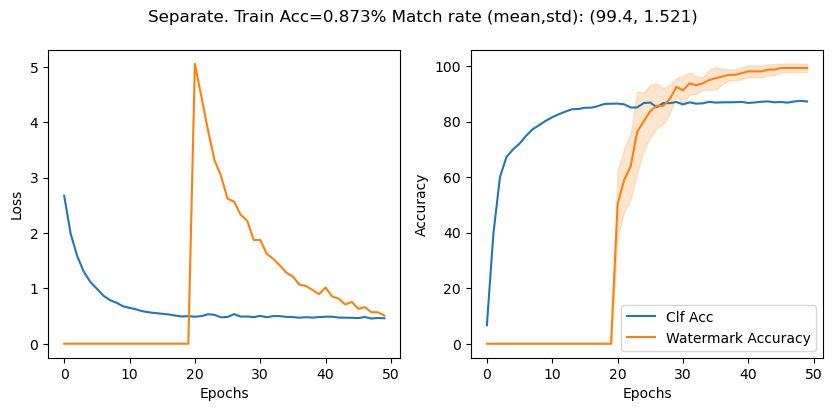

In [6]:

# for _ in range(3):
# for mom in [1e-3, 1e-2, 1e-1, 0.5]:
#     for rho in [1e-7,1e-5,1e-3]:
# config.optimization_kwargs['sam_momentum'] = mom
# config.optimization_kwargs['sam_rho'] = rho
# for i in range(10):
#     if i<5:
#         config.optimization_kwargs['use_sam']=True
#         title = f'With SAM - momentum={np.round(config.optimization_kwargs['sam_momentum'],3)}, rho={config.optimization_kwargs['sam_rho']}'
#     else:
# config.optimization_kwargs['use_sam']=False
for _ in range(1):
    config.optimization_kwargs['perturb_x']=False
    config.optimization_kwargs['separate_forward_passes_per_subgraph']=True
    title = f'Separate'
    Trainer_ = Trainer(data, dataset_name)
    node_classifier, history, subgraph_dict, \
    all_feature_importances, all_watermark_indices, probas = Trainer_.train(debug_multiple_subgraphs=False, save=True, print_every=1)

    primary_loss_curve, watermark_loss_curve, final_betas, watermarks, \
    percent_matches, percent_match_mean, percent_match_std, \
        primary_acc_curve, watermark_acc_curve, train_acc, val_acc = get_performance_trends(history, subgraph_dict)
    final_plot(history, title, percent_matches, primary_loss_curve, watermark_loss_curve, train_acc)  
# for _ in range(1):
#     config.optimization_kwargs['perturb_x']=False
#     config.optimization_kwargs['separate_forward_passes_per_subgraph']=False
#     title = f'Not Separate'
#     Trainer_ = Trainer(data, dataset_name)
#     node_classifier, history, subgraph_dict, \
#     all_feature_importances, all_watermark_indices, probas = Trainer_.train(debug_multiple_subgraphs=False, save=True, print_every=1)

#     primary_loss_curve, watermark_loss_curve, final_betas, watermarks, \
#     percent_matches, percent_match_mean, percent_match_std, \
#         primary_acc_curve, watermark_acc_curve, train_acc, val_acc = get_performance_trends(history, subgraph_dict)
#     final_plot(history, title, percent_matches, primary_loss_curve, watermark_loss_curve, train_acc)  
# for _ in range(1):
#     config.optimization_kwargs['perturb_x']=False
#     title = f'Vanilla'
#     Trainer_ = Trainer(data, dataset_name)
#     node_classifier, history, subgraph_dict, \
#     all_feature_importances, all_watermark_indices, probas = Trainer_.train(debug_multiple_subgraphs=False, save=True, print_every=1)

#     primary_loss_curve, watermark_loss_curve, final_betas, watermarks, \
#     percent_matches, percent_match_mean, percent_match_std, \
#         primary_acc_curve, watermark_acc_curve, train_acc, val_acc = get_performance_trends(history, subgraph_dict)
#     final_plot(history, title, percent_matches, primary_loss_curve, watermark_loss_curve, train_acc)  
# for _ in range(1):
#     config.optimization_kwargs['separate_forward_passes_per_subgraph']=True
#     title = f'Separate Forward Passes for D_trn and D_wmk'
#     Trainer_ = Trainer(data, dataset_name)
#     node_classifier, history, subgraph_dict, \
#     all_feature_importances, all_watermark_indices, probas = Trainer_.train(debug_multiple_subgraphs=False, save=True, print_every=1)

#     primary_loss_curve, watermark_loss_curve, final_betas, watermarks, \
#     percent_matches, percent_match_mean, percent_match_std, \
#         primary_acc_curve, watermark_acc_curve, train_acc, val_acc = get_performance_trends(history, subgraph_dict)
#     final_plot(history, title, percent_matches, primary_loss_curve, watermark_loss_curve, train_acc)  

In [7]:
Trainer_.optimizer.zero_grad()
log_logits          = Trainer_.forward(data.x, data.edge_index, dropout=config.node_classifier_kwargs['dropout'])


acc_trn = accuracy(log_logits[Trainer_.train_mask], data.y[Trainer_.train_mask],verbose=False)
acc_val = accuracy(log_logits[Trainer_.val_mask],   data.y[Trainer_.val_mask],verbose=False)

In [8]:
sig = list(Trainer_.subgraph_dict.keys())[0]
node_indices = Trainer_.subgraph_dict[sig]['nodeIndices']
Trainer_.x#[node_indices]

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [10., 10.,  0.,  ...,  0., 10.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [10., -9.,  0.,  ...,  0.,  0.,  0.],
        [ 1., -9., -9.,  ..., -9.,  0., -9.],
        [10., 10.,  0.,  ..., 10., 10.,  0.]])

In [9]:
Trainer_.forward(data.x, data.edge_index, dropout=0)


tensor([[-2.5135, -2.0671, -2.5162,  ..., -2.5989, -2.0855, -2.4737],
        [-2.9204, -2.0398, -3.1309,  ..., -3.5097, -1.9472, -3.0037],
        [-2.6028, -2.2278, -2.8592,  ..., -2.9719, -1.3860, -2.3866],
        ...,
        [-2.9182, -2.6029, -2.9013,  ..., -3.2258, -1.1315, -2.7037],
        [-3.1914, -1.7261, -3.4235,  ..., -3.5965, -1.5664, -3.1513],
        [-1.9254, -2.5194, -2.0963,  ..., -2.5219, -1.8731, -2.4154]],
       grad_fn=<LogSoftmaxBackward0>)

In [10]:
def shift_subgraph(self, p_to_swap, subgraph_node_indices):
    num_to_swap = int(p_to_swap*len(subgraph_node_indices))
    random_indices = torch.randperm(len(subgraph_node_indices))
    subgraph_node_indices = subgraph_node_indices[random_indices[:len(subgraph_node_indices)-num_to_swap]]
    filtered_tensor = Trainer_.train_nodes_to_consider[~Trainer_.train_nodes_to_consider.unsqueeze(1).eq(subgraph_node_indices).any(dim=1)]
    random_index = torch.randint(0, filtered_tensor.size(0), (num_to_swap,))
    random_element = filtered_tensor[random_index]
    subgraph_node_indices = torch.concatenate([subgraph_node_indices, random_element])

    sub_edge_index, _ = subgraph(subgraph_node_indices, self.data.edge_index, relabel_nodes=True, num_nodes=self.data.num_nodes)
    shifted_subgraph = Data(
        x          = self.data.x[subgraph_node_indices]          if self.data.x is not None else None,
        edge_index = sub_edge_index,
        y          = self.data.y[subgraph_node_indices]          if self.data.y is not None else None,
        train_mask = self.data.train_mask[subgraph_node_indices] if self.data.train_mask is not None else None,
        test_mask  = self.data.test_mask[subgraph_node_indices]  if self.data.test_mask is not None else None,
        val_mask   = self.data.val_mask[subgraph_node_indices]   if self.data.val_mask is not None else None)
    return shifted_subgraph






In [11]:
Trainer_.percent_matches

[100.0, 100.0, 100.0, 95.65217391304348, 100.0, 100.0, 100.0]

In [12]:
Trainer_.node_classifier.eval()
Trainer_.optimizer.zero_grad()


log_logits   = Trainer_.forward(data.x, data.edge_index, dropout=0)
print('Full prediction accuracies:')
for i, sig in enumerate(Trainer_.subgraph_dict.keys()):
    node_indices = Trainer_.subgraph_dict[sig]['nodeIndices']
    these_out = log_logits[node_indices]
    these_y = data.y[node_indices]
    acc = accuracy(these_out, these_y, verbose=False)
    print(acc)
for p_to_swap in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]:
    matches = []
    sign_betas = []
    for i, sig in enumerate(Trainer_.subgraph_dict.keys()):
        node_indices = Trainer_.subgraph_dict[sig]['nodeIndices']
        num_to_swap = int(p_to_swap*len(node_indices))

        # print('node indices start:', node_indices)
        random_indices = torch.randperm(len(node_indices))
        node_indices = node_indices[random_indices[:len(node_indices)-num_to_swap]]
        filtered_tensor = Trainer_.train_nodes_to_consider[~Trainer_.train_nodes_to_consider.unsqueeze(1).eq(node_indices).any(dim=1)]
        random_index = torch.randint(0, filtered_tensor.size(0), (num_to_swap,))
        random_element = filtered_tensor[random_index]
        node_indices = torch.concatenate([node_indices, random_element])
        # print('node indices end  :', node_indices)

        sub_edge_index, _ = subgraph(node_indices, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)
        subgraph_ = Data(
            x=data.x[node_indices] if data.x is not None else None,
            edge_index=sub_edge_index,
            y=data.y[node_indices] if data.y is not None else None,
            train_mask=data.train_mask[node_indices] if data.train_mask is not None else None,
            test_mask=data.test_mask[node_indices] if data.test_mask is not None else None,
            val_mask=data.val_mask[node_indices] if data.val_mask is not None else None)
    

        x_sub, edge_index_sub = subgraph_.x, subgraph_.edge_index
        these_log_logits   = Trainer_.forward(x_sub, edge_index_sub, dropout=config.node_classifier_kwargs['dropout'])
        these_probas = these_log_logits.clone().exp()
        y_sub = these_probas

        watermark_loss_kwargs = config.watermark_loss_kwargs
        regression_kwargs = config.regression_kwargs
        this_watermark = subgraph_dict[sig]['watermark']#[subgraph_dict[sig][k] for k in ['watermark','subgraph','nodeIndices']]


        ''' epoch condtion: epoch==epoch-1'''
        omit_indices,not_omit_indices = get_omit_indices(x_sub, this_watermark,ignore_zeros_from_subgraphs=False) #indices where watermark is 0
        this_raw_beta = solve_regression(x_sub, y_sub, regression_kwargs['lambda'])
        beta  = process_beta(this_raw_beta, watermark_loss_kwargs['alpha'], omit_indices, watermark_loss_kwargs['scale_beta_method'])
        these_watermark_indices = Trainer_.all_watermark_indices[i]
        #print('watermark:',this_watermark[these_watermark_indices])
        #print('beta:     ',torch.sign(beta[these_watermark_indices]))
        match = torch.sum(this_watermark[these_watermark_indices]==torch.sign(beta[these_watermark_indices]))/len(these_watermark_indices)
        sign_betas.append(torch.sign(beta[these_watermark_indices]))
        match_str = str(np.round(100*match.item(),3)) + '%'
        matches.append(match_str)
    print(f'Match rates when replacing {int(100*p_to_swap)}% watermark subgraph indices:')
    print(matches)
    bs = torch.vstack(sign_betas)
    match_counts= count_matches(bs)
    print('match counts across subgraphs:',match_counts)


Full prediction accuracies:
tensor(0.8679, dtype=torch.float64)
tensor(0.8679, dtype=torch.float64)
tensor(0.8113, dtype=torch.float64)
tensor(0.8113, dtype=torch.float64)
tensor(0.8113, dtype=torch.float64)
tensor(0.9434, dtype=torch.float64)
tensor(0.8679, dtype=torch.float64)
Match rates when replacing 0% watermark subgraph indices:
['100.0%', '100.0%', '100.0%', '95.652%', '100.0%', '100.0%', '100.0%']
match counts across subgraphs: 22
Match rates when replacing 5% watermark subgraph indices:
['100.0%', '95.652%', '95.652%', '91.304%', '95.652%', '86.957%', '100.0%']
match counts across subgraphs: 16
Match rates when replacing 10% watermark subgraph indices:
['91.304%', '78.261%', '82.609%', '86.957%', '100.0%', '86.957%', '86.957%']
match counts across subgraphs: 8
Match rates when replacing 15% watermark subgraph indices:
['82.609%', '82.609%', '91.304%', '86.957%', '95.652%', '86.957%', '78.261%']
match counts across subgraphs: 8
Match rates when replacing 20% watermark subgraph

In [13]:
len(these_watermark_indices)

23

In [14]:
tensor = Trainer_.train_nodes_to_consider

# Separate list of elements to exclude
exclude_tensor = node_indices

# Convert exclude_list to a tensor for comparison
# exclude_tensor = torch.tensor(exclude_list)

# Filter the original tensor to exclude elements in the exclude list
filtered_tensor = tensor[~tensor.unsqueeze(1).eq(exclude_tensor).any(dim=1)]
random_index = torch.randint(0, filtered_tensor.size(0), (5,))
random_element = filtered_tensor[random_index]
node_indices = torch.concatenate([node_indices, random_element])

In [15]:
Trainer_.x[torch.tensor(list(set(np.concatenate(Trainer_.all_watermark_indices))))]

tensor([[ 1.,  1.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
        [ 0., 10.,  0.,  ..., 10.,  0., 10.],
        ...,
        [10.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., -9.,  0.,  ...,  0., -9.,  0.]])

In [16]:
config.node_classifier_kwargs.keys()

dict_keys(['arch', 'activation', 'nLayers', 'hDim', 'dropout', 'dropout_subgraphs', 'skip_connections', 'heads_1', 'heads_2', 'inDim', 'outDim'])

In [17]:

''' (individualize boolean, multisubgraph method, index selection method) '''
selection_kwargss = [#(False, None, 'random'), # random, not individualized
                    (False,'average','unimportant'), # average, not individualized
                    #(False,'concat','unimportant'), # concat, not inividualized
                    # (True,None,'unimportant') # unimportant, individualized
                    ]

''' (method, regenerate_boolean) '''
subgraph_methods = [('random',False)]

''' [subset, percentage] '''
sacrifice_kwargss = [['train_node_indices',1],['train_node_indices',0.75],['subgraph_node_indices',1],[None,None]]

''' (method, L2_lambda (if applicable, else None) '''
regularization_kwargs = [(None,None),('L2',0.01),('beta_var',None)]


variables = {'augment': [{'separate_trainset_from_subgraphs': True,
                          'ignore_subgraphs': True,
                          'nodeDrop': False,
                          'nodeMixUp': False,
                          'nodeFeatMask': False,
                          'edgeDrop': False},
                          {'separate_trainset_from_subgraphs': True,
                          'ignore_subgraphs': True,
                          'nodeDrop': True,
                          'nodeMixUp': True,
                          'nodeFeatMask': True,
                          'edgeDrop': True},],
             'sacrifice_kwargs':  sacrifice_kwargss,
             'beta_selection': selection_kwargss,
             'use_PCgrad': [True,False],
             'subgraph_method': subgraph_methods,
             'reg': regularization_kwargs,
             'perc': [3],
             'clf_epochs': [10,20],
             'coef_wmk': [200,600],
             'frac': [0.02],
             'num_subgraphs': [2,7],
             'balance_beta_weights': [True,False],
             'ignore_subgraph_neighbors': [True, False]}




# config.optimization_kwargs['clf_only']=False       
# watermarking_order = ['augment','use_PCgrad','sacrifice_kwargs','beta_selection','subgraph_method','reg','perc','clf_epochs','frac','coef_wmk','num_subgraphs','balance_beta_weights','ignore_subgraph_neighbors']
# print("watermarking:", watermarking_order)
# count, [node_classifier, history, subgraph_dict,\
#          all_feature_importances, all_watermark_indices, probas] = dynamic_grid_search(data, dataset_name, debug_multiple_subgraphs, 
#                                                                                        all_dfs, False, variables, watermarking_order,
#                                                                                        count_only=True)
# print(count)


config.augment_kwargs['separate_trainset_from_subgraphs'] = True
config.augment_kwargs['ignore_subgraphs'] = True
perturb=False
perturb_lr = 1e-3
node_classifier, history, subgraph_dict, \
    all_feature_importances, all_watermark_indices, probas = train(data, dataset_name, debug_multiple_subgraphs=False, save=True, print_every=1,perturb=perturb,perturb_lr=perturb_lr)
primary_loss_curve, watermark_loss_curve, final_betas, watermarks, \
    percent_matches, percent_match_mean, percent_match_std, \
        primary_acc_curve, watermark_acc_curve, train_acc, val_acc = get_performance_trends(history, subgraph_dict)
final_plot(history, '', percent_matches, primary_loss_curve, watermark_loss_curve, train_acc)  



NameError: name 'train' is not defined

In [ ]:
data.x[all]

IndexError: only integers, slices (`:`), ellipsis (`...`), None and long or byte Variables are valid indices (got builtin_function_or_method)

In [ ]:
folder = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/computers/archGCN_elu_nLayers3_hDim256_drop0_skipTrue/_3%UnimportantIndices_average_10ClfEpochs_random_fraction0.01_numSubgraphs10_eps0.1_raw_beta_nodeMixUp40_lr0.002_epochs80_coefWmk200_regressionLambda0.1'
probas = pickle.load(open(f'{folder}/probas','rb'))
subgraph_dict = pickle.load(open(f'{folder}/subgraph_dict','rb'))
all_watermark_indices = pickle.load(open(f'{folder}/all_watermark_indices','rb'))
node_classifier = pickle.load(open(f'{folder}/node_classifier','rb'))
history = pickle.load(open(f'{folder}/history','rb'))


In [ ]:
data

NameError: name 'data' is not defined

In [ ]:
import nlopt
import numpy as np

# Define your objective function
def objective(x, grad):
    if grad.size > 0:
        # Compute gradient if needed
        x_tensor = torch.tensor(x, dtype=torch.float32).reshape(original_shape)
        x_tensor.requires_grad = True
        log_logits_sub = node_classifier(x_tensor, edge_index)
        probas_sub = log_logits_sub.clone().exp()

        omit_indices, not_omit_indices = get_omit_indices(x_tensor, this_watermark, ignore_zeros_from_subgraphs=False)
        raw_beta = solve_regression(x_tensor, probas_sub, regression_kwargs['lambda'])
        beta = process_beta(raw_beta, watermark_loss_kwargs['alpha'], omit_indices, watermark_loss_kwargs['scale_beta_method'])
        B_x_W = (beta * this_watermark).clone()
        B_x_W = B_x_W[not_omit_indices]
        balanced_beta_weights = torch.ones_like(B_x_W)
        balanced_beta_weights = balanced_beta_weights[not_omit_indices]
        loss = torch.mean(torch.clamp(watermark_loss_kwargs['epsilon'] - B_x_W, min=0) * balanced_beta_weights)
        loss.backward()

        grad[:] = x_tensor.grad.numpy().flatten()

    return loss.item()

ModuleNotFoundError: No module named 'nlopt'

In [ ]:

from scipy.optimize import minimize
results = []
for sig in subgraph_dict.keys():
    watermark_loss_kwargs = config.watermark_loss_kwargs
    regression_kwargs = config.regression_kwargs
    this_watermark, data_sub, subgraph_node_indices = [subgraph_dict[sig][k] for k in ['watermark','subgraph','nodeIndices']]
    x_sub = data_sub.x
    edge_index = data_sub.edge_index
    original_shape = x_sub.shape
    x_sub_flat = x_sub.flatten()
    # global i
    # i = 0
    def compute_watermark_loss(x_sub_flat):
        # global i
        # i+=1
        # print(/i,end='\r')
        # print('hi')
        x_sub = torch.tensor(x_sub_flat, dtype=torch.float32).reshape(original_shape)
        balanced_beta_weights = torch.ones(x_sub.shape[1])

        log_logits_sub = node_classifier(x_sub, edge_index)
        probas_sub = log_logits_sub.clone().exp()


        omit_indices,not_omit_indices = get_omit_indices(x_sub, this_watermark,ignore_zeros_from_subgraphs=False) #indices where watermark is 0
        raw_beta            = solve_regression(x_sub, probas_sub, regression_kwargs['lambda'])
        beta                = process_beta(raw_beta, watermark_loss_kwargs['alpha'], omit_indices, watermark_loss_kwargs['scale_beta_method'])
        B_x_W = (beta*this_watermark).clone()
        B_x_W = B_x_W[not_omit_indices]
        balanced_beta_weights = balanced_beta_weights[not_omit_indices]
        this_loss_watermark = torch.mean(torch.clamp(watermark_loss_kwargs['epsilon']-B_x_W, min=0)*balanced_beta_weights)
        loss_watermark  = this_loss_watermark
        # print('ok')
        return loss_watermark.item()

    # Ensure maxiter is enforced and debugging output
    options = {'maxfun': 2, 'iprint':110, 'maxls':2, 'maxiter':2}

    # Use the L-BFGS-B algorithm for optimization
    result = minimize(compute_watermark_loss, x_sub_flat, 
                      method='L-BFGS-B', 
                      options=options)

    # The optimal x found by the optimizer
    results.append(result)
    # print(result)


_minimize_lbfgsb options: 2 2
_prepare_scalar_function
C
D
F
init
update_fun: <function ScalarFunction.__init__.<locals>.update_fun at 0x3170d3880>
fun_wrapped
args: ()
FD_METHODS
finite_diff_options: {'method': '2-point', 'rel_step': None, 'abs_step': 1e-08, 'bounds': (array([-inf, -inf, -inf, ..., -inf, -inf, -inf]), array([inf, inf, inf, ..., inf, inf, inf]))}
Help on function update_grad in module scipy.optimize._differentiable_functions:

update_grad()

update_grad: None
not self.g_updated
approx deriv
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_wrapped
args: ()
fun_

KeyboardInterrupt: 

In [ ]:
scipy.optimize

<module 'scipy.optimize' from '/opt/homebrew/Caskroom/miniforge/base/envs/proj_2_env/lib/python3.12/site-packages/scipy/optimize/__init__.py'>

In [ ]:
len(set(torch.wherae(torch.eq(data_copy.x, data.x)==False)[1].tolist()))

767

In [ ]:
data.x[24,0]

tensor(0.)

In [ ]:
data_copy.x[[24,25],[0,1]]

tensor([-4.8543e-05,  0.0000e+00])

In [ ]:
import torch

t = torch.tensor([1,12])
t.numpy()

array([ 1, 12])

In [ ]:
def get_beta_weights(subgraph_dict, num_features):
    if config.watermark_loss_kwargs['balance_beta_weights'] == True:
        beta_weights = get_balanced_beta_weights([subgraph_dict[sig]['subgraph'] for sig in subgraph_dict.keys()])
    elif config.watermark_loss_kwargs['balance_beta_weights'] == False:
        beta_weights = torch.ones(len(subgraph_dict),num_features)
    return beta_weights

def process_beta(beta, alpha, omit_indices, scale_beta_method='clip'):
    if scale_beta_method=='tanh':
        beta = torch.tanh(alpha*beta)
    elif scale_beta_method=='tan':
        beta = torch.tan(alpha*beta)
    elif scale_beta_method=='clip':
        beta = torch.clip(beta,min=-1,max=1)
    elif scale_beta_method==None:
        pass
    beta = beta.clone()  # Avoid in-place operation
    if omit_indices is not None and len(omit_indices)>0:
        beta[omit_indices] = 0 # zero out non-contributing indices
    return beta

def compute_watermark_loss(subgraph_dict, probas, beta_weights):
    watermark_loss_kwargs = config.watermark_loss_kwargs
    regression_kwargs = config.regression_kwargs
    optimization_kwargs = config.optimization_kwargs

    loss_watermark = torch.tensor(0.0)
    for s, sig in enumerate(subgraph_dict.keys()):
        this_watermark, data_sub, subgraph_node_indices = [subgraph_dict[sig][k] for k in ['watermark','subgraph','nodeIndices']]
        x_sub, y_sub = data_sub.x, probas[subgraph_node_indices]
        ''' epoch condtion: epoch==epoch-1'''
        omit_indices,not_omit_indices = get_omit_indices(x_sub, this_watermark,ignore_zeros_from_subgraphs=False) #indices where watermark is 0
        raw_beta            = solve_regression(x_sub, y_sub, regression_kwargs['lambda'])
        beta                = process_beta(raw_beta, watermark_loss_kwargs['alpha'], omit_indices, watermark_loss_kwargs['scale_beta_method'])
        B_x_W = (beta*this_watermark).clone()
        B_x_W = B_x_W[not_omit_indices]

        balanced_beta_weights = beta_weights[s]
        balanced_beta_weights = balanced_beta_weights[not_omit_indices]
        loss_watermark = loss_watermark+torch.mean(torch.clamp(watermark_loss_kwargs['epsilon']-B_x_W, min=0)*balanced_beta_weights)


    loss_watermark = loss_watermark/len(subgraph_dict)
    loss_watermark_scaled = loss_watermark*optimization_kwargs['coefWmk']
    return loss_watermark_scaled


beta_weights = get_beta_weights(subgraph_dict, data.x.shape[1])
all_subgraph_indices = []
for sig in subgraph_dict.keys():
    nodeIndices = subgraph_dict[sig]['nodeIndices']
    all_subgraph_indices+=nodeIndices.tolist()
reg_copy=None


lr = 0.002
optimizer = optim.Adam(node_classifier.parameters(), lr=lr)


for j in range(100):
    x_copy,edge_index_copy = copy.deepcopy(data).x, copy.deepcopy(data).edge_index
    x_copy = x_copy.requires_grad_(True)
    #with torch.no_grad():
    #    edge_index_copy, x_copy, _ = augment_data(data, node_aug, edge_aug, train_nodes_to_consider, all_subgraph_indices)
    #    x_copy = x_copy.requires_grad_(True)
    log_logits_copy          = node_classifier(x_copy, edge_index_copy)
    probas_copy = log_logits_copy.clone().exp()
    loss_watermark_scaled_copy = compute_watermark_loss(subgraph_dict, probas_copy, beta_weights)
    wmk_loss = loss_watermark_scaled_copy+reg_copy if reg_copy is not None else loss_watermark_scaled_copy
    optimizer.zero_grad()
    wmk_loss.backward()
    print(f'{j}/20: {wmk_loss:3f}',end='\r')
    this_grad = torch.zeros_like(data.x)
    this_grad[all_subgraph_indices] = x_copy.grad.clone()[all_subgraph_indices]
    this_grad[all_subgraph_indices] = (this_grad[all_subgraph_indices]-this_grad[all_subgraph_indices].mean())/(this_grad[all_subgraph_indices].max()-this_grad[all_subgraph_indices].min())
    x_grad_wmk_loss = torch.zeros_like(data.x)
    x_grad_wmk_loss[all_subgraph_indices] = this_grad.clone()[all_subgraph_indices]
    # print(x_grad_wmk_loss[all_subgraph_indices])
    data.x = data.x - perturb_lr*x_grad_wmk_loss
    optimizer.zero_grad()

KeyboardInterrupt: 

In [ ]:
beta_weights = get_beta_weights(subgraph_dict, data.x.shape[1])
for s, sig in enumerate(subgraph_dict.keys()):
    this_watermark, data_sub, subgraph_node_indices = [subgraph_dict[sig][k] for k in ['watermark','subgraph','nodeIndices']]
    x_sub, y_sub = data_sub.x, probas[subgraph_node_indices]
    ''' epoch condtion: epoch==epoch-1'''
    omit_indices,not_omit_indices = get_omit_indices(x_sub, this_watermark,ignore_zeros_from_subgraphs=False) #indices where watermark is 0
    print(not_omit_indices)

tensor([  7,  11,  23,  34,  37,  41,  43,  69,  73,  86,  97, 105, 109, 110,
        134, 144, 154, 159, 168, 177, 185, 186, 195, 212, 217, 219, 225, 227,
        238, 250, 259, 277, 279, 284, 298, 328, 355, 358, 363, 365, 367, 376,
        382, 386, 427, 430, 439, 442, 443, 457, 489, 503, 506, 507, 515, 520,
        542, 544, 554, 559, 582, 597, 617, 649, 664, 687, 695, 698, 704, 708,
        715, 729, 732, 747, 755, 758])


In [ ]:
subgraph_dict.keys()

dict_keys(['11293_4896_5573_3951_10751_63'])